In [2]:
!ls

Dockerfile  docker-compose.yaml  overrides.json
README.md   notebooks		 requirements.txt


In [103]:
import re
from music21 import *
import os
import pandas as pd

def get_subfolders_names(path):
    return [x[0] for x in os.walk(path)]

def get_files_with_prefix(path, prefix):
    return [each for each in os.listdir(path) if each.startswith(prefix)]

def read_files_in_directory(path, prefix):
    files = get_files_with_prefix(path, prefix)
    contents = []
    for file in files:
        with open(path+'/'+file, 'r') as f:
            content = f.read()
            contents.append(content)
    return dict(zip(files,contents))
    
def get_songs_from_sample(sample):
    sample_split = '---------------\n'
    current_songs= sample.split(sample_split)[:-1]
    ignore_lines =5
    current_song = ''
    initial_song = '\n'.join(current_songs[0].splitlines()[5:7])
    remaining_songs = current_songs[1:]
    remaining_songs = ['\n'.join(sample_song.splitlines()[:2]) for sample_song in remaining_songs]
    song_samples = [initial_song]+remaining_songs
    print('num. song samples:',len(song_samples))
    return song_samples
def format_model_output(abc_song_model_output):
    header_chars = ['M','L','K']
    pattern = re.compile(r'([{}])'.format(''.join(header_chars)))
    formatted_song = pattern.sub(r' \1', abc_song_model_output)
    #print(formatted_song.split())
    header_M,header_L,aux_header_K,song_body= formatted_song.split()
    index = aux_header_K.find('|')
    header_K = aux_header_K[:index]
    header_comment = '%'+aux_header_K[index:]
    song_metadata = [header_M,header_L,header_K,header_comment,song_body]
    formatted_song = '\n'.join(song_metadata)
    return dict(zip(['M','L','K','chord_prog'],song_metadata)),formatted_song

def parse_abc_song(formatted_abc_song):
    #print([formatted_abc_song])
    return converter.parse(formatted_abc_song, format='abc')

def get_song_key_obj(song_metadata):
    song_key_metadata = abcFormat.ABCMetadata(song_metadata['K'])
    song_key_metadata.preParse()
    return song_key_metadata.getKeySignatureObject()

def get_song_notes(formatted_abc_string):
    parsed_abc_song = converter.parse(formatted_abc_string, format='abc')
    current_pitches = parsed_abc_song.pitches
    return current_pitches
    
def get_song_key(song_stream):
    return song_stream.analyze('key')

def metric_notes_in_key_rate(parsed_abc_song,key_song_obj):
    song_notes = [pitch.name for pitch in parsed_abc_song.pitches]
    key_notes = [key_pitch.name for key_pitch in key_song_obj.pitches]

    total_notes = len(song_notes)

    notes_in_key = 0
    notes_not_in_key = 0
    rate = 0
    for current_note in song_notes:
        if current_note in key_notes:
            notes_in_key += 1
        else:
            notes_not_in_key += 1

    if notes_in_key !=0:    
        rate = notes_in_key/total_notes 
    metric_data = {
        'notes_in_key_rate':rate,
        'total_notes':total_notes,
        'notes_in_key':notes_in_key,
        'notes_not_in_key':notes_not_in_key
    }
    return metric_data

def get_metrics(formatted_abc_song,song_metadata):
    
    parsed_song = parse_abc_song(formatted_abc_song)
    current_key = get_song_key_obj(song_metadata)
    
    metric_data = metric_notes_in_key_rate(parsed_song,current_key)
    
    return metric_data


In [80]:
current_song = '''M:4/4L:1/4K:Am|"Am"|"Dm"|"E"|"E"|"Am"|"Dm"|"E"|"Am"|]
e|"Am"A/2c/2c/2c/2c/2B/2c/2A/2|
'''
current_metadata, formatted_current_song = format_model_output(current_song)
get_metrics(formatted_current_song,current_metadata)

{'notes_in_key_rate': 1.0,
 'total_notes': 12,
 'notes_in_key': 12,
 'notes_not_in_key': 0}

In [5]:
from music21 import *
abc_string = """
X:1
T:Example
M:4/4
L:1/4
K:G
"I"^G/2_A/2B/2A/2G/2F/2|G/2A/2B/2A/2G/2F/2|"IV"E3/4F/4G/2E/2|C/2C/2C/2|"V"B,2|"I"G/2A/4G/2F/2E/2|"IV"C/2C/2C/2D/2E/2|"V"F/2B,/2D/2C/2B,/2|"I"G/2G/2G/2A/2|"IV"G/2A/4G/4F/4G/2|"V"F/2G/2F/2D/2|"I"E2|]
"""
abc_score = converter.parse(abc_string, format='abc')
len(abc_score.pitches)

49

In [6]:
abcFormat.ABCFile.extractReferenceNumber(abc_string, 1)

'X:1\nT:Example\nM:4/4\nL:1/4\nK:G\n"I"^G/2_A/2B/2A/2G/2F/2|G/2A/2B/2A/2G/2F/2|"IV"E3/4F/4G/2E/2|C/2C/2C/2|"V"B,2|"I"G/2A/4G/2F/2E/2|"IV"C/2C/2C/2D/2E/2|"V"F/2B,/2D/2C/2B,/2|"I"G/2G/2G/2A/2|"IV"G/2A/4G/4F/4G/2|"V"F/2G/2F/2D/2|"I"E2|]\n'

In [7]:
dict(zip(['M','L','K'],['1','2','3']))

{'M': '1', 'L': '2', 'K': '3'}

In [36]:
current_song_metadata, current_song_formatted = format_model_output(current_song)
abch = abcFormat.ABCHandler()
abch.tokenize(current_song_formatted)
print(current_song_formatted)
key_obj = get_song_key_obj(current_song_metadata)
[key_pitch.name for key_pitch in key_obj.pitches]

['M:4/4', 'L:1/4', 'K:Am|"Am"|"Dm"|"E"|"E"|"Am"|"Dm"|"E"|"Am"|]', 'E|"Am"A3/2B/2A|"Am"e2e3/2d/2|"Dm"B3/2c/2A3/2B/2|"E"G/2E/2E3/2F/2G3/2B/2|"E"e3/2f/2e3/2d/2|"Am"B3/2c/2A3/2B/2|"Dm"c3/2d/2e3/2f/2|"E"e3/2d/2B3/2A/2|"Am"B3/2c/2A3/2B/2|"Dm"c/2d3/2e/2f3/2e/2|"E"e3/2d/2B3/2d/2|"Am"B/2A3/2c/2A3/2B/2|"Dm"c3/2d/2e3/2f/2|"E"e3/2d/2B3/2d/2|"Am"B3/2A/2A3/2B/2|"Dm"c3/2A/2B3/2c/2|"E"e3/2B/2e3/2d/2|"Am"B3/2c/2A3/2B/2|"D"c3/2d/2e3/2f/2|"E"e3/2d/2B3/2d/2|"Am"B/2A3/2A/2B3/2c/2|"D"d3/2A/2B3/2c/2|"E"B3/2A/2G3/2B/2|"Am"A3|]']
M:4/4
L:1/4
K:Am
%|"Am"|"Dm"|"E"|"E"|"Am"|"Dm"|"E"|"Am"|]
E|"Am"A3/2B/2A|"Am"e2e3/2d/2|"Dm"B3/2c/2A3/2B/2|"E"G/2E/2E3/2F/2G3/2B/2|"E"e3/2f/2e3/2d/2|"Am"B3/2c/2A3/2B/2|"Dm"c3/2d/2e3/2f/2|"E"e3/2d/2B3/2A/2|"Am"B3/2c/2A3/2B/2|"Dm"c/2d3/2e/2f3/2e/2|"E"e3/2d/2B3/2d/2|"Am"B/2A3/2c/2A3/2B/2|"Dm"c3/2d/2e3/2f/2|"E"e3/2d/2B3/2d/2|"Am"B3/2A/2A3/2B/2|"Dm"c3/2A/2B3/2c/2|"E"e3/2B/2e3/2d/2|"Am"B3/2c/2A3/2B/2|"D"c3/2d/2e3/2f/2|"E"e3/2d/2B3/2d/2|"Am"B/2A3/2A/2B3/2c/2|"D"d3/2A/2B3/2c/2|"E"B3/2A/2G3/2B/

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'A']

['M:4/4', 'L:1/4', 'K:Am|"Am"|"Dm"|"E"|"E"|"Am"|"Dm"|"E"|"Am"|]', 'E|"Am"A3/2B/2A|"Am"e2e3/2d/2|"Dm"B3/2c/2A3/2B/2|"E"G/2E/2E3/2F/2G3/2B/2|"E"e3/2f/2e3/2d/2|"Am"B3/2c/2A3/2B/2|"Dm"c3/2d/2e3/2f/2|"E"e3/2d/2B3/2A/2|"Am"B3/2c/2A3/2B/2|"Dm"c/2d3/2e/2f3/2e/2|"E"e3/2d/2B3/2d/2|"Am"B/2A3/2c/2A3/2B/2|"Dm"c3/2d/2e3/2f/2|"E"e3/2d/2B3/2d/2|"Am"B3/2A/2A3/2B/2|"Dm"c3/2A/2B3/2c/2|"E"e3/2B/2e3/2d/2|"Am"B3/2c/2A3/2B/2|"D"c3/2d/2e3/2f/2|"E"e3/2d/2B3/2d/2|"Am"B/2A3/2A/2B3/2c/2|"D"d3/2A/2B3/2c/2|"E"B3/2A/2G3/2B/2|"Am"A3|]']
-------------------------
Key A minor
In Key:  160
Not in Key: 10
-------------------------


<music21.graph.plot.HistogramPitchClass for <music21.stream.Stream 0x7f287a948610>>

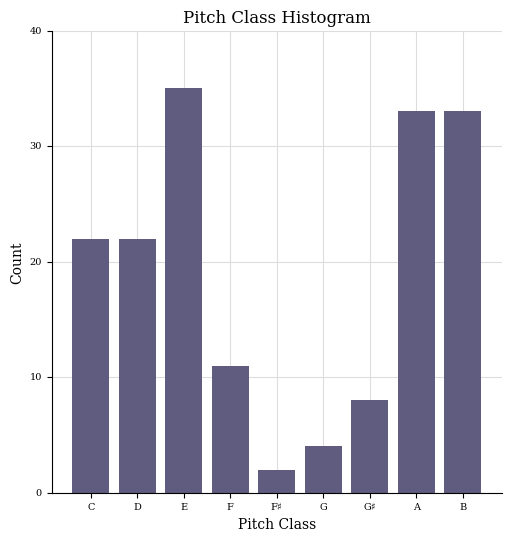

In [9]:
other_abc_string = """
X:1
T:Example
M:4/4
L:1/4
K:G
"G"G/2A/2B/2A/2G/2F/2|G/2A/2B/2A/2G/2F/2|"IV"E3/4F/4G/2E/2|C/2C/2C/2|"V"B,2|"I"G/2A/4G/2F/2E/2|"IV"C/2C/2C/2D/2E/2|"V"F/2B,/2D/2C/2B,/2|"I"G/2G/2G/2A/2|"IV"G/2A/4G/4F/4G/2|"V"F/2G/2F/2D/2|"I"E2|]
"""
current_song_metadata, current_song_formatted = format_model_output(current_song)
examples_stream = stream.Stream()
abc_scores = [current_song_formatted]
streams = []
for abc_song in abc_scores:
    print('-----'*5)
    parsed_abc_song = converter.parse(abc_song, format='abc')
    examples_stream.insert(examples_stream.highestTime, parsed_abc_song)
    current_key = parsed_abc_song.analyze('key')
    current_key_pitches = [key_pitch.name for key_pitch in current_key.pitches]
    current_pitches = parsed_abc_song.pitches
    count_pitches_in_key = 0
    count_pitches_not_in_key = 0
    for pitch in current_pitches:
        if pitch.name in current_key_pitches:
            count_pitches_in_key += 1
        else:
            count_pitches_not_in_key += 1
    print('Key',current_key.name)
    print('In Key: ', count_pitches_in_key)
    print('Not in Key:', count_pitches_not_in_key)
    print('-----'*5)
examples_stream.plot('histogram', 'pitchClass')

<music21.graph.plot.HistogramPitchSpace for <music21.stream.Stream 0x7f287a948610>>

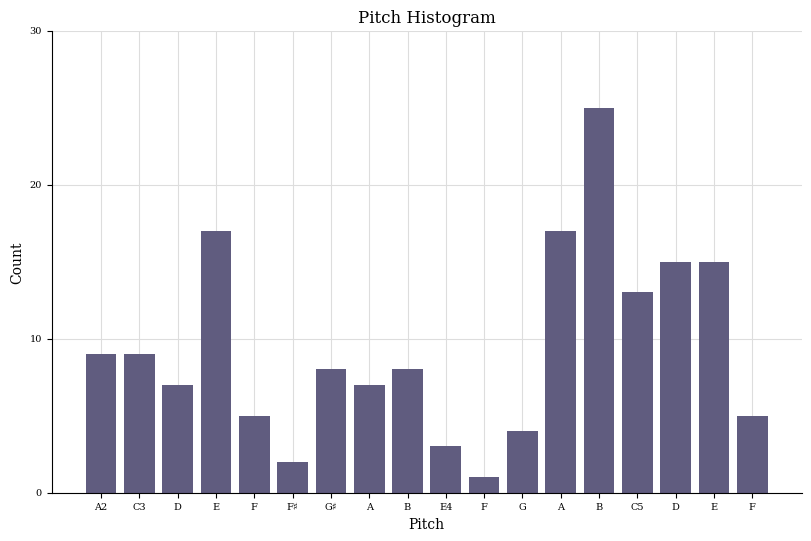

In [10]:
examples_stream.plot('histogram', 'pitch')

In [11]:
something =abcFormat.ABCMetadata(current_song).preParse()


In [12]:
A = ['M', 'K', 'L', '|']
B = "hello... (world)!"
pattern = re.compile(r'([{}])'.format(''.join(A)))
new_string = pattern.sub(r' \1', B)
new_string

'hello... (world)!'

In [59]:
samples = get_songs_from_sample(example)
for sample in samples:
    metadata, formatted_sample = format_model_output(sample)
    print(formatted_sample)
print('')

num. song samples: 10
['M:4/4', 'L:1/4', 'K:C|"I"|"IV"|"V"|"V"|"I"|"IV"|"V"|"I"|]', 'C/2A,/2|"I"A,/2C/2A,/2A,/2|A,/2C/2E/2C/2E/2|"I"A,/2A,/2C/2A,/2A,/2|"IV"A,/2A,/2A,/2D/2F/2C/2|"V"A2CB,|"V"A,3/2C/2A,A,|"I"A,/2C/2A,/2C/2A,/2C/2E,/2C/2|"IV"F,/2D/2F/2D/2F/2C/2F/2C/2|"V"A,/2A,/2C/2D/2C/2B,/2C/2F,|"V"A,/2C/2C/2CA,C|"I"A,/2C/2A,/2A,/2A,/2C/2A,/2C/2|A,/2C/2A,/2C/2E/2C/2E/2C/2E/2C/2|"IV"A']
M:4/4
L:1/4
K:C
%|"I"|"IV"|"V"|"V"|"I"|"IV"|"V"|"I"|]
C/2A,/2|"I"A,/2C/2A,/2A,/2|A,/2C/2E/2C/2E/2|"I"A,/2A,/2C/2A,/2A,/2|"IV"A,/2A,/2A,/2D/2F/2C/2|"V"A2CB,|"V"A,3/2C/2A,A,|"I"A,/2C/2A,/2C/2A,/2C/2E,/2C/2|"IV"F,/2D/2F/2D/2F/2C/2F/2C/2|"V"A,/2A,/2C/2D/2C/2B,/2C/2F,|"V"A,/2C/2C/2CA,C|"I"A,/2C/2A,/2A,/2A,/2C/2A,/2C/2|A,/2C/2A,/2C/2E/2C/2E/2C/2E/2C/2|"IV"A
['M:4/4', 'L:1/4', 'K:C|"I"|"IV"|"V"|"V"|"I"|"IV"|"V"|"I"|]', 'a/2b/2|"I"c\'3/4b/4c\'3/4b/4|"IV"a/2g3/2f/2|"V"e/2f3/4g/4|"V"c3/4d/4c3/4d/4|"I"e3/2g/4|"IV"a3/4g/4a3/4b/4|c\'/2c\'3/4b/4c\'3/4']
M:4/4
L:1/4
K:C
%|"I"|"IV"|"V"|"V"|"I"|"IV"|"V"|"I"|]
a/2b/2|"I"c'3

In [95]:
def get_songs_from_dataset(tuneBook):
    songs_in_tuneBook=tuneBook.split('\n\n')[:-1]
    return songs_in_tuneBook

def get_song_metadata(formatted_song):
    header_M,header_L,header_K,aux_header_K,song_body= formatted_song.split('\n')
    header_comment = '%'+aux_header_K
    song_metadata = [header_M,header_L,header_K,header_comment,song_body]
    formatted_song = '\n'.join(song_metadata)
    return dict(zip(['M','L','K','chord_prog'],song_metadata)),formatted_song
my_tuneBook = '''M:4/4
L:1/4
K:Bm
|"i"|"i"|"VII"|"VII"|"i"|"i"|"V"|"i"|"i"|"i"|"VII"|"VII"|"i""VII"|"i""V"|"iv""V"|"i"|]
F|"i"BBB,B,/2C/2|"i"D/2C/2D/2E/2F/2E/2F/2^G/2|"VII"AAA,A,/2B,/2|"VII"C/2E/2A/2F/2E/2C/2B,/2A,/2|"i"BBB,B,/2C/2|"i"D/2C/2D/2E/2F/2E/2F/2^G/2|A/2G/2F/2E/2"V"F/2E/2D/2C/2|"i"B,2B,|F|"i"FBB3/2A/2|"i"F/2A/2B/2c/2d/2c/2B/2A/2|"VII"EAA3/2F/2|"VII"E/2F/2A/2B/2c/2B/2A/2c/2|"i"BF"VII"dF|"i"eF"V"f3/2e/2|"iv"d/2c/2B/2A/2"V"F/2d/2c/2d/2|"i"B2B|]

M:4/4
L:1/4
K:A
|"I"|"ii""V"|"I"|"V""I"|"I"|"ii"|"V"|"I"|"I"|"ii"|"V"|"I"|"IV""V"|"I"|"V"|"I"|"II"|"V"|"I"|"ii"|"I""V"|"I"|]
E|"I"AECE|"ii"FD"V"B,D|"I"CEA3/2B/2|"V"c/2d/2c/2B/2"I"AE|"I"AECE|"ii"FDB,D|"V"C3/2B,/2A,G,|"I"A,3C/2D/2|"I"E3/2D/2CD|EAcE|"ii"FAdc|"V"B/2c/2B/2A/2GC/2D/2|"I"E3/2D/2CD|EAcE|"IV"Fd"V"c/2B/2A/2G/2|"I"A3G/2A/2|"V"B3/2G/2EE|"I"c3/2A/2EE|"II"^dBcd|"V"edcB|"I"AECE|"ii"FDB,D|"I"CE"V"A3/2B/2|"I"A3|]

'''
songs_in_tunebook = get_songs_from_dataset(my_tuneBook)

metadata_in_tunebook, formatted_song_tunebook = get_song_metadata(songs_in_tunebook[0])
print(metadata_in_tunebook)
print(formatted_song_tunebook)

{'M': 'M:4/4', 'L': 'L:1/4', 'K': 'K:Bm', 'chord_prog': '%|"i"|"i"|"VII"|"VII"|"i"|"i"|"V"|"i"|"i"|"i"|"VII"|"VII"|"i""VII"|"i""V"|"iv""V"|"i"|]'}
M:4/4
L:1/4
K:Bm
%|"i"|"i"|"VII"|"VII"|"i"|"i"|"V"|"i"|"i"|"i"|"VII"|"VII"|"i""VII"|"i""V"|"iv""V"|"i"|]
F|"i"BBB,B,/2C/2|"i"D/2C/2D/2E/2F/2E/2F/2^G/2|"VII"AAA,A,/2B,/2|"VII"C/2E/2A/2F/2E/2C/2B,/2A,/2|"i"BBB,B,/2C/2|"i"D/2C/2D/2E/2F/2E/2F/2^G/2|A/2G/2F/2E/2"V"F/2E/2D/2C/2|"i"B,2B,|F|"i"FBB3/2A/2|"i"F/2A/2B/2c/2d/2c/2B/2A/2|"VII"EAA3/2F/2|"VII"E/2F/2A/2B/2c/2B/2A/2c/2|"i"BF"VII"dF|"i"eF"V"f3/2e/2|"iv"d/2c/2B/2A/2"V"F/2d/2c/2d/2|"i"B2B|]


In [109]:
something ={}
print(something)
something['hi'] = 5
print(something)
something['yo'] ='Yooo!'
pd.DataFrame([something])

{}
{'hi': 5}


,hi,yo
0,5,Yooo!


In [110]:
something ={}
print(something)
something['hi'] = 5
print(something)
something['yo'] ='Yooo!'
pd.DataFrame.from_dict(something,orient='index').T

df = pd.DataFrame()

for row in [1,2,3,4,5]:
    row_to_append = pd.DataFrame([something])
    df = pd.concat([df, row_to_append])

df

{}
{'hi': 5}


,hi,yo
0,5,Yooo!
0,5,Yooo!
0,5,Yooo!
0,5,Yooo!
0,5,Yooo!


In [111]:
def analyse_abc_songs(experiments,experiments_prefix='examples',is_experiment=True):
    experiment_errors = {}
    total_errors_count = 0
    metrics_df = pd.DataFrame()
    experiment_name_and_location = experiments.items()
    for experiment_name,experiment_path in experiment_name_and_location:
        experiment_samples = read_files_in_directory(experiment_path,experiments_prefix)
        
        print(experiment_name)
        sample_errors = {}
        sample_errors_count = 0

        for sample_name in experiment_samples.keys():
            experiment_example = experiment_samples[sample_name]
            if is_experiment:
                print(sample_name)
            if is_experiment:
                sample_songs = get_songs_from_sample(experiment_example)
            else:
                sample_songs = get_songs_from_dataset(experiment_example)

            for sample in sample_songs:
                try:
                    if is_experiment:
                        metadata, formatted_sample = format_model_output(sample)
                    else:
                        metadata, formatted_sample = get_song_metadata(sample)
                        
                    current_metric = get_metrics(formatted_sample,metadata)

                    current_metric['song_formatted'] = formatted_sample
                    current_metric['sample_name'] = sample_name
                    current_metric['experiment_name'] = experiment_name
                    
                    metrics_row = pd.DataFrame([current_metric])    
                    metrics_df = pd.concat([metrics_df, metrics_row])               
                except Exception as e:
                    print('Error Found!!!')
                    sample_errors_count += 1
                    if sample_name in sample_errors:
                        sample_errors[sample_name].append(f'caught {type(e)}: e')
                    else:
                        sample_errors[sample_name] = [f'caught {type(e)}: e']
        
        experiment_errors[experiment_name] = sample_errors
        print('errors_in_sample:',sample_errors_count)
        total_errors_count += sample_errors_count
        print('-----'*10)
    print('total_errors:',total_errors_count)
    return experiment_errors,metrics_df

In [112]:
experiments_main_path = './notebooks/nanoGPT/older_ckpt/'
experiments_paths = get_subfolders_names(experiments_main_path)[1:]    
experiments = {path.split('/')[-1]:path for path in experiments_paths}
experiments
errors_found,experiments_metrics = analyse_abc_songs(experiments)
experiments_metrics

hd-8-ly-12-embd-240
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-8-ly-12-embd-280
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-8-ly-12-embd-368
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd_8_ly_6_bch_84
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-8-ly-12-embd-320
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
---------------------------------------

abcFormat: WARNING: Could not get pitch information from note:  ^, assuming C


examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-8-ly-12-bt-1
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-8-ly-12-rn-data
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-12-ly-12-rn-data
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
errors_in_sample: 0
--------------------------------------------------
hd-8-ly-12
examples_C.txt
num. song samples: 10
examples_G.txt
num. song samples: 10
examples_Am.txt
num. song samples: 10
Error Found!!!
errors_in_sample: 1
--------------------------------------------------
hd-8-ly-12-bt-64
examples_C.txt
num. song samples: 10
examples_G.txt
num. song

,notes_in_key_rate,total_notes,notes_in_key,notes_not_in_key,song_formatted,sample_name,experiment_name
0,1.000000,96,96,0,"M:4/4\nL:1/4\nK:C\n%|""C""|""F""|""G""|""G""|""C""|""F""|""...",examples_C.txt,hd-8-ly-12-embd-240
0,1.000000,143,143,0,"M:4/4\nL:1/4\nK:C\n%|""C""|""F""|""G""|""G""|""C""|""F""|""...",examples_C.txt,hd-8-ly-12-embd-240
0,1.000000,82,82,0,"M:4/4\nL:1/4\nK:C\n%|""C""|""F""|""G""|""G""|""C""|""F""|""...",examples_C.txt,hd-8-ly-12-embd-240
0,0.985507,69,68,1,"M:4/4\nL:1/4\nK:C\n%|""C""|""F""|""G""|""G""|""C""|""F""|""...",examples_C.txt,hd-8-ly-12-embd-240
0,0.974747,198,193,5,"M:4/4\nL:1/4\nK:C\n%|""C""|""F""|""G""|""G""|""C""|""F""|""...",examples_C.txt,hd-8-ly-12-embd-240
...,...,...,...,...,...,...,...
0,0.892857,84,75,9,"M:4/4\nL:1/4\nK:Am\n%|""Am""|""Dm""|""E""|""E""|""Am""|""...",examples_Am.txt,embd_396
0,0.916667,96,88,8,"M:4/4\nL:1/4\nK:Am\n%|""Am""|""Dm""|""E""|""E""|""Am""|""...",examples_Am.txt,embd_396
0,0.926829,82,76,6,"M:4/4\nL:1/4\nK:Am\n%|""Am""|""Dm""|""E""|""E""|""Am""|""...",examples_Am.txt,embd_396
0,0.931034,87,81,6,"M:4/4\nL:1/4\nK:Am\n%|""Am""|""Dm""|""E""|""E""|""Am""|""...",examples_Am.txt,embd_396


In [78]:
errors_found

{'hd-8-ly-12-embd-240': {},
 'hd-8-ly-12-embd-280': {},
 'hd-8-ly-12-embd-368': {},
 'hd_8_ly_6_bch_84': {},
 'hd-8-ly-12-embd-320': {},
 'hd-8-ly-16-rn-data': {},
 'hd-12-ly-12': {},
 'm_voices': {},
 'hd-8-ly-12-bt-4': {},
 'hd-8-ly-12-bt4-ovrf': {},
 'hd-8-ly-16': {},
 't_data': {},
 'hd-8-ly-12-bt-8': {},
 'hd-8-ly-12-bt-16': {},
 'hd-8-ly-12-bt-1': {},
 'hd-8-ly-12-rn-data': {},
 'hd-12-ly-12-rn-data': {},
 'hd-8-ly-12': {'examples_Am.txt': ["caught <class 'music21.abcFormat.ABCHandlerException'>: e"]},
 'hd-8-ly-12-bt-64': {},
 'hd_8_ly_6_bch_48': {},
 'hd-8-ly-12-bt-4-rn-data': {},
 'hd-8-ly-12-bt-4-ctx-256': {},
 'hd-8-ly-12-bt-4-ctx-1024': {},
 'single_voice': {},
 'embd_396': {}}

In [99]:
datasets_main_path = './notebooks/nanoGPT/data/'
datasets_paths = get_subfolders_names(datasets_main_path)[1:]    
original_data_paths = {path.split('/')[-1]:path for path in datasets_paths}
original_data_paths

{'abc_roman_num_char': './notebooks/nanoGPT/data/abc_roman_num_char',
 'abc_char': './notebooks/nanoGPT/data/abc_char'}

In [101]:
errors_found = analyse_abc_songs(original_data_paths,
                                experiments_prefix='input',
                                is_experiment=False)

errors_in_sample: 0
--------------------------------------------------
errors_in_sample: 0
--------------------------------------------------
total_errors: 0
